In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [123]:
def calculate_moving_average(bid_prices, ask_prices, window):
    """
    Calculates the moving average of a given list of bid and ask prices.

    Args:
        bid_prices (list): A list of bid prices.
        ask_prices (list): A list of ask prices.
        window (int): The number of prices to consider in the moving average calculation.

    Returns:
        tuple: A tuple containing the moving average of the bid prices and the moving average of the ask prices.

    Raises:
        None

    """
    if len(bid_prices) < window:
        return None, None  # Not enough data to calculate
    return (sum(bid_prices[-window:]) / window), (sum(ask_prices[-window:]) / window)

def calculate_order_book_imbalance(cur_row):
    """
    Calculate the order book imbalance for a given row of data.

    Parameters:
    cur_row (pandas.Series): The row of data containing bid and ask volumes.

    Returns:
    float: The order book imbalance value.

    """
    total_buy_volume = 0
    total_sell_volume = 0

    # Calculate the total buy and sell volume
    for i in range(1, 4):
        if not np.isnan(cur_row['bid_volume_{}'.format(i)]):
            total_buy_volume += cur_row['bid_volume_{}'.format(i)]
        if not np.isnan(cur_row['ask_volume_{}'.format(i)]):
            total_sell_volume += cur_row['ask_volume_{}'.format(i)]
            
    total_volume = total_buy_volume + total_sell_volume
    if total_volume == 0:  # Prevent division by zero
        return 0
    imbalance = (total_buy_volume - total_sell_volume) / total_volume
    return imbalance

# Load the data
imc_data = pd.read_csv('imc_data.csv')
imc_data.set_index('timestamp', inplace=True)
starfruit_data = imc_data[imc_data['product'] == 'STARFRUIT']
amethyst_data = imc_data[imc_data['product'] == 'AMETHYST']
miraclefruit_data = pd.read_csv('MIRACLEFRUIT.csv')

SHORT_TERM_WINDOW = 24    # Window for short-term moving average
LONG_TERM_WINDOW = 165  # Window for long-term moving average
IMBALANCE_THRESHOLD = 0.2   # Threshold for order book imbalance


In [128]:
def backTestProduct(product, data):

    product_data = data[data['product'] == product]

    trade_log = []
    position_open = False
    position_type = None
    end_row = LONG_TERM_WINDOW

    for timestamp, row in product_data.iloc[LONG_TERM_WINDOW:].iterrows():

        cur_data = product_data.iloc[:end_row]

        # Get the current bids, and asks
        cur_bid = row['bid_price_1']
        cur_ask = row['ask_price_1']

        # Get the historical bid and ask prices
        bid_prices = cur_data['bid_price_1'].tolist()
        ask_prices = cur_data['ask_price_1'].tolist()

        # Calculate the moving averages
        bid_short_term_ma, ask_short_term_ma = calculate_moving_average(bid_prices, ask_prices, SHORT_TERM_WINDOW)
        bid_long_term_ma, ask_long_term_ma = calculate_moving_average(bid_prices, ask_prices, LONG_TERM_WINDOW)

        # Calculate the order book imbalance
        imbalance = calculate_order_book_imbalance(row)

        if bid_short_term_ma is None or bid_long_term_ma is None:
            print('Not enough data to calculate moving averages at:', row['timestamp'])
            continue

        if not position_open:

            if ask_short_term_ma > ask_long_term_ma and imbalance > IMBALANCE_THRESHOLD:
                # Anticipate upward movement, long signal
                trade_log.append({'timestamp': timestamp, 
                                  'action': 'open position',
                                  'price': cur_ask, 
                                  'type': 'long',
                                  'shares': 1})
                position_open = True
                position_type = 'long'
            elif bid_short_term_ma < bid_long_term_ma and imbalance < -IMBALANCE_THRESHOLD:
                # Anticipate downward movement, short signal
                trade_log.append({'timestamp': timestamp, 
                                  'action': 'open position',
                                  'price': cur_bid, 
                                  'type': 'short',
                                  'shares': 1})
                position_open = True
                position_type = 'short'
        elif position_open:

            if position_type == 'long' and bid_short_term_ma < bid_long_term_ma:
                # Close long position
                trade_log.append({'timestamp': timestamp, 
                                  'action': 'close position',
                                  'price': cur_bid, 
                                  'type': 'long',
                                  'shares': 1})
                position_open = False
                position_type = None
            elif position_type == 'short' and ask_short_term_ma > ask_long_term_ma:
                # Close short position
                trade_log.append({'timestamp': timestamp, 
                                  'action': 'close position',
                                  'price': cur_ask, 
                                  'type': 'short',
                                  'shares': 1})
                position_open = False
                position_type = None

        end_row += 1
    
    trade_log_df = pd.DataFrame(trade_log)
    trade_log_df.to_csv('{}_trade_log.csv'.format(product), index=False)

    totalReturns = 0
    openPosition = None
    closePositionDates = []
    closePositionReturns = []

    for index, trade in trade_log_df.iterrows():
        if trade['action'] == 'open position':
            openPosition = trade
        elif trade['action'] == 'close position' and openPosition is not None:
            closePositionDates.append(trade['timestamp'])

            if openPosition['type'] == 'long':
                returns = (trade['price'] - openPosition['price']) * openPosition['shares']
            elif openPosition['type'] == 'short':
                returns = (openPosition['price'] - trade['price']) * openPosition['shares']
            
            totalReturns += returns
            closePositionReturns.append(returns)
            openPosition = None
    
    pnlDf = pd.DataFrame(closePositionReturns, index=closePositionDates, columns=['pnl'])
    pnlDf['cumulative_pnl'] = pnlDf['pnl'].cumsum()
    pnlDf.reset_index(inplace=True, names='timestamp')
    pnlDf.to_csv('{}_pnl.csv'.format(product))
            


backTestProduct('STARFRUIT', imc_data)
backTestProduct('AMETHYSTS', imc_data)
backTestProduct('MIRACLEFRUIT', miraclefruit_data)

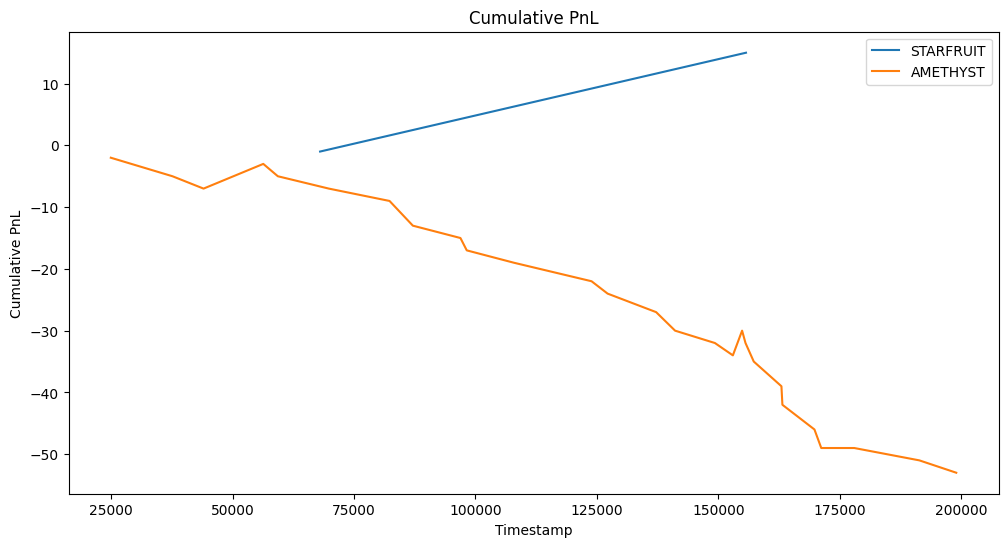

In [133]:
# Load the PnL data
starfruit_returns = pd.read_csv('STARFRUIT_pnl.csv')
amethyst_returns = pd.read_csv('AMETHYSTS_pnl.csv')
miraclefruit_returns = pd.read_csv('MIRACLEFRUIT_pnl.csv')

# Plot the cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(starfruit_returns['timestamp'], starfruit_returns['cumulative_pnl'], label='STARFRUIT')
plt.plot(amethyst_returns['timestamp'], amethyst_returns['cumulative_pnl'], label='AMETHYST')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL')
plt.legend()
plt.show()



In [ ]:
bestReturns = -float('inf')
bestShortMAWindow = None
bestLongMAWindow = None
bestImbalanceThreshold = None

for imbalanceThreshold in [x / 10 for x in range(1, 10)]:
    for shortTermMAWindow in range(5, 50, 5):
        for longTermMAWindow in range(50, 200, 5):

            trade_log = []
            position_open = False
            position_type = None
            
            
            # Strategy
            end_row = longTermMAWindow * 2
            for timestamp, cur_row in starfruit_data.iloc[longTermMAWindow * 2:].iterrows():

                cur_data = starfruit_data.iloc[:end_row]


                # Get the current row, bids, and asks
                cur_bid = int(cur_row['bid_price_1'])
                cur_ask = int(cur_row['ask_price_1'])
                bid_prices = cur_data['bid_price_1'].tolist()
                ask_prices = cur_data['ask_price_1'].tolist()

                # Calculate the moving averages
                bid_short_term_ma, ask_short_term_ma = calculate_moving_average(bid_prices, ask_prices, shortTermMAWindow)
                bid_long_term_ma, ask_long_term_ma = calculate_moving_average(bid_prices, ask_prices, longTermMAWindow)

                # Calculate the order book imbalance
                imbalance = calculate_order_book_imbalance(cur_row)

                # Check if moving averages are calculated
                if bid_short_term_ma is None or bid_long_term_ma is None:
                    print('Not enough data to calculate moving averages')
                    continue

                # Check if there is an open position
                if position_open:

                    if position_type == 'long' and bid_short_term_ma < bid_long_term_ma:
                        trade_log.append({
                            'Date': timestamp,
                            'Action': 'Close Position',
                            'Type': 'Long',
                            'Shares': 1,
                            'Price': cur_bid,
                            })
                        position_open = False
                        position_type = None
                    elif position_type == 'short' and ask_short_term_ma > ask_long_term_ma:
                        trade_log.append({
                            'Date': timestamp,
                            'Action': 'Close Position',
                            'Type': 'Short',
                            'Shares': 1,
                            'Price': cur_ask,
                            })
                        position_open = False
                        position_type = None
                
                elif not position_open:
                    
                    if ask_short_term_ma > ask_long_term_ma and imbalance > imbalanceThreshold:
                        trade_log.append({
                            'Date': timestamp,
                            'Action': 'Open Position',
                            'Type': 'Long',
                            'Shares': 1,
                            'Price': cur_ask,
                            })
                        position_open = True
                        position_type = 'long'
                    elif bid_short_term_ma < bid_long_term_ma and imbalance < -imbalanceThreshold:
                        trade_log.append({
                            'Date': timestamp,
                            'Action': 'Open Position',
                            'Type': 'Short',
                            'Shares': 1,
                            'Price': cur_bid,
                            })
                        position_open = True
                        position_type = 'short'

                end_row += 1
            
            trade_log_df = pd.DataFrame(trade_log)
            totalReturn = 0
            open_position = None
            close_position = None
            close_position_dates = []
            close_position_returns = []

            for index, trade in trade_log_df.iterrows():
                if trade['Action'] == 'Open Position':
                    open_position = trade
                elif trade['Action'] == 'Close Position':
                    close_position = trade
                    close_position_dates.append(trade['Date'])
                    if open_position['Type'] == 'Long':
                        profitLoss = (trade['Price'] - open_position['Price']) * open_position['Shares']
                    elif open_position['Type'] == 'Short':
                        profitLoss = (open_position['Price'] - trade['Price']) * open_position['Shares']
                    totalReturn += profitLoss
                    close_position_returns.append(profitLoss)
                    open_position = None
            
            if totalReturn > bestReturns:
                bestReturns = totalReturn
                bestShortMAWindow = shortTermMAWindow
                bestLongMAWindow = longTermMAWindow
                bestImbalanceThreshold = imbalanceThreshold

print("Best Returns:", bestReturns)
print("Best Short MA Window:", bestShortMAWindow)
print("Best Long MA Window:", bestLongMAWindow)
print("Best Imbalance Threshold:", bestImbalanceThreshold)          


Best Returns: 24
Best Short MA Window: 45
Best Long MA Window: 165
Best Imbalance Threshold: 0.2
